<a href="https://colab.research.google.com/github/rohailkhan/Stackover-flow-Data-analysis/blob/master/Seattle_Airbnb_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import test1 as t
import seaborn as sns
%matplotlib inline


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option("display.max_columns", None)

In [5]:
calendar=pd.read_csv('/content/drive/MyDrive/A Udacity Data scientist/Lesson 1/calendar.csv')
listings=pd.read_csv('/content/drive/MyDrive/A Udacity Data scientist/Lesson 1/listings.csv')
reviews=pd.read_csv('/content/drive/MyDrive/A Udacity Data scientist/Lesson 1/reviews.csv')

In [6]:

#'property_type', 'room_type', 'bed_type' ,'size'
# ans NO:  ,'size'
# 'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed' # None present
columns_to_keep=['id',
 'host_location',
  'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city','price',
 'state',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 ##
 'room_type', 'bed_type',##
 'accommodates',
 'bathrooms',
 'bedrooms',
 'amenities',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'review_scores_rating',
 'review_scores_cleanliness',
 'review_scores_location',
 'cancellation_policy']

In [7]:
def clean_listings(df):
    df=df[columns_to_keep]
    change_to_float_columns=['cleaning_fee','extra_people', 'price']
    for col in change_to_float_columns:
        df[col]=df[col].str.replace("$","").str.replace(",","").str.replace("%","").astype(float).copy()
    fill_mean_columns=['cleaning_fee','review_scores_rating','review_scores_cleanliness','review_scores_location']
    for col in fill_mean_columns:
        df[col]=df[col].fillna(df[col].mean())
    outlier_columns=['price', 'extra_people', 'cleaning_fee','bathrooms','bedrooms']
    for col in outlier_columns:
        df[col]=np.where(df[col]>df[col].quantile(0.80),df[col].quantile(0.80),df[col])
    # dropping small number of null values for numeric columns
    df.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)
    # dropping small number of null values for object columns
    df.dropna(subset=['host_neighbourhood','host_location','host_has_profile_pic','host_identity_verified','property_type','neighbourhood'], inplace=True)
    df['amenities']=df['amenities'].str.strip('{}').str.replace('"','').str.split(',')
    h=[]
    for i in df.amenities:
        h.append(len(i))
    df['amenities_number']=h
    
    df.drop(columns=['id','amenities'],inplace=True)
    ## making dummy variables for categorical data
    
    # for col in categorical_features:
    #     try:
    #         df=pd.concat([df.drop(col,axis=1)  , pd.get_dummis(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    #     except:
    #         continue
    categorical_features=df.select_dtypes(include=['object']).columns
    for col in categorical_features:
        df=pd.concat([df.drop(col,axis=1)  , pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    X=df.drop(['price'],axis=1)
    y=df[['price']]
    
    return X,y,df


In [8]:
X,y,df=clean_listings(listings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [13]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score


In [10]:
from sklearn.preprocessing import StandardScaler

In [14]:

def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return best_cutoff, reduce_X ,r2_scores_test , r2_scores_train , lm_model , X_train , X_test , y_train, y_test

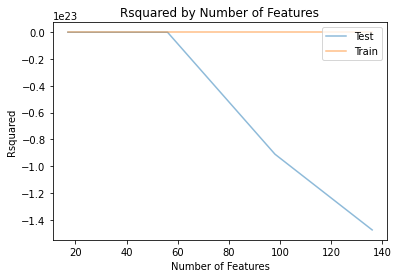

In [15]:
cutoffs = [ 3000, 2500, 2000,1800,1200,1000,400,250,200,150, 100, 50, 30]
best_cutoff, reduce_X ,r2_scores_test , r2_scores_train , lm_model , X_train , X_test , y_train, y_test=find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True)
   

In [16]:
best_cutoff

'200'

In [17]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2



35
0.5905600174216361
0.5280611757545224


In [12]:
type(X_train),type(y_train),type(X_test),type(y_test),type(reduce_X),type(lm_model.coef_)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray)

In [13]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,reduce_X.shape,lm_model.coef_.shape

((2360, 35), (2360, 1), (1012, 35), (1012, 1), (3372, 35), (1, 35))

In [19]:
len(X_train.columns),len(y_train),len(X_test.columns),len(y_test),len(reduce_X.columns),len(lm_model.coef_)

(35, 2360, 35, 1012, 35, 1)

In [18]:
  y_test_preds = lm_model.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_test_preds, squared=False)

28.824713194787115

In [26]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_.T
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_.T)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
20,neighbourhood_Capitol Hill,46.571412,46.571412
28,city_Seattle,45.133119,45.133119
16,host_neighbourhood_Capitol Hill,-41.578080,41.578080
31,room_type_Private room,-25.489424,25.489424
25,neighbourhood_group_cleansed_Downtown,22.148703,22.148703
32,bed_type_Real Bed,21.209711,21.209711
0,latitude,-18.297969,18.297969
27,neighbourhood_group_cleansed_Queen Anne,17.436805,17.436805
3,bedrooms,14.784958,14.784958
2,bathrooms,14.104145,14.104145


In [25]:
X_train.columns

Index(['latitude', 'accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'amenities_number',
       'host_location_Seattle, Washington, United States',
       'host_neighbourhood_Ballard', 'host_neighbourhood_Belltown',
       'host_neighbourhood_Capitol Hill', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'neighbourhood_Ballard',
       'neighbourhood_Capitol Hill', 'neighbourhood_cleansed_Belltown',
       'neighbourhood_cleansed_Broadway',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Other neighborhoods',
       'neighbourhood_group_cleansed_Queen Anne', 'city_Seattle',
       'is_location_exact_t', 'property_type_House', 'room_type_Private room',
       '

In [24]:
X_train.shape, lm_model.coef_.shape ,lm_model.coef_.T.shape

((2360, 35), (1, 35), (35, 1))